# Asset Pricing and Portfolio Management #

Suppose that an investor owns, on September 25th, 2008 a portfolio worth \$10 million consisting of
investments in four stock indices: Dow Jones Industrial Average (DJIA) in the United States, the FTSE
100 in the United Kingdom, the CAC 40 in France, and the Nikkei 225 in Japan. So, let’s suppose that today is September 25th, 2008.
The value of the investment in each index on September 25, 2008, is (in \$ 000s): \$4000 in DJIA, \$3000
in FTSE, \$1000 in CAC and \$2000 in NIKKEI.

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch.univariate import arch_model
import datetime

<AxesSubplot:xlabel='Day'>

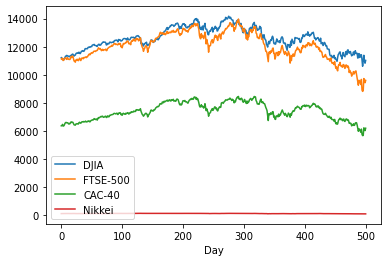

In [85]:
indexes    = pd.read_excel('stock_indexes.xls','for_python',index_col=0)
portfolio  = [4000,3000,1000,2000]
indexes.plot()

## Question 1 : Using a GARCH model (1,1), estimate the tomorrow's volatility of each of the four indices. Compare the values obtained. Is the result in line with your expectations ? ##



The $garch(p,q)$ model calculates the daily volatility forecast from the $p$ most recent observations $u$
and the $q$ most recent variances $\sigma^2$ :

$$ \sigma_t^2 = \omega + \sum_{i=0}^{p}\alpha_i u_{t-i}^2 + \sum_{i=0}^{q}\beta_i \sigma_{t-i}^2$$

$$ \sigma_t^2 = \omega + \alpha_0 u_t^2 + \alpha_1 u_{t-1}^2 + ... + \alpha_p u_{t-p}^2 + \beta_0 \sigma_t^2 + \beta_1 \sigma_{t-1}^2 + ... + \beta_q \sigma_{t-q}^2$$

With the simplest and most popular $garch(1,1)$ model : \
$$ \sigma_t^2 = \omega + \alpha u_{t-1}^2 + \beta \sigma_{t-1}^2 $$
with :
* $u_{t-1}$ the latest market news
* $\sigma_{t-1}$ the lastest standard deviation

In [86]:
# We start with the calculation of returns (we have the index levels and not the returns)
returns = pd.DataFrame()
for column_name in indexes.columns:
    returns.insert(len(returns.columns), column_name , indexes[column_name].pct_change() + 1)

# We drop the first line because without a previous line to compute a return, it displays NaN
returns = returns.iloc[1: , :]

# We use normalized returns for the GARCH model to focus on the variance
demeaned_returns = returns - np.mean(returns)
demeaned_returns

,DJIA,FTSE-500,CAC-40,Nikkei
Day,,,,
1,-0.004107,-0.002999,0.000628,0.020001
2,-0.008744,0.008223,0.014990,0.011834
3,0.004325,-0.014881,-0.018045,-0.003502
4,-0.003294,0.002376,0.001103,-0.009663
5,0.000862,0.006425,0.010470,0.015656
...,...,...,...,...
496,0.038621,0.006768,0.002198,-0.023167
497,0.033437,0.096593,0.094891,0.019124
498,-0.032757,-0.007793,-0.007755,0.014642


In [87]:
# p=1, q=1 : forecast lengths. Both at 1 for garch(1, 1)
# o=0 : no integration (different from IGARCH)
omegas = []
alphas = []
betas = []

for column_name in indexes.columns:
    am = arch_model(100 * np.array(demeaned_returns[column_name]), mean='zero',p=1, o=0, q=1)
    garch_result = am.fit()
    print(garch_result.summary())
    omegas.append(garch_result.params[0])
    alphas.append(garch_result.params[1])
    betas.append(garch_result.params[2]) 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 267847.3261533039
Iteration:      2,   Func. Count:     11,   Neg. LLF: 701.4429297753443
Iteration:      3,   Func. Count:     16,   Neg. LLF: 3716.666322349747
Iteration:      4,   Func. Count:     21,   Neg. LLF: 817.1578226289529
Iteration:      5,   Func. Count:     26,   Neg. LLF: 699.8670551411744
Iteration:      6,   Func. Count:     31,   Neg. LLF: 1246.419345225507
Iteration:      7,   Func. Count:     36,   Neg. LLF: 269254.04751957895
Iteration:      8,   Func. Count:     43,   Neg. LLF: 701.1986773172243
Iteration:      9,   Func. Count:     48,   Neg. LLF: 833.3076500952891
Iteration:     10,   Func. Count:     53,   Neg. LLF: 692.0031128130515
Iteration:     11,   Func. Count:     58,   Neg. LLF: 689.6821553463033
Iteration:     12,   Func. Count:     62,   Neg. LLF: 689.6168276769419
Iteration:     13,   Func. Count:     76,   Neg. LLF: 2392.147690329456
Iteration:     14,   Func. Count:     86,   Neg. LLF: 723.33891

In [88]:
tomorrow_variances = []
for i in range(len(indexes.columns)) :
    tomorrow_variances.append(omegas[i] + alphas[i] * indexes.iloc[-1, i]**2 + betas[i] * returns.iloc[-1, i]**2)
    # utiliser cette formule ou seulement la VL = omega / (1 - alpha - beta) ?
    # quid si omega = 0 (cf ci-dessous : correction des coefficients)
    
tomorrow_volatility = np.sqrt(tomorrow_variances)
print(tomorrow_volatility)
print(tomorrow_volatility / indexes.tail(1))

[1658.14731585 3872.3376488  2239.15986676   41.36102066]
         DJIA  FTSE-500    CAC-40    Nikkei
Day                                        
500  0.150439  0.403373  0.361132  0.366604


We check in the summaries that, for each index, the P values of the $\omega$, $\alpha$ and $\beta$ parameters are acceptable, ie that for each, $(P>|t|) < 0.05$.

For the DJIA :
* $\omega = 0.00359$ with $P>|t|= 0.702 > 0.05$ : the error margin is too high, the coefficient is not significant and should be dropped
* $\alpha = 0.0226$ with $P>|t|= 0.437 > 0.05$ : the error margin is too high, the coefficient is not significant and should be dropped
* $\beta = 0.9774$ with $P>|t| ~ 10^{-130} < 0.05$ : the error margin is considered null : the coefficient is helpful

For the FTSE-500 :
* $\omega = 0.0249$ with $P>|t|= 0.226 > 0.05$ : the error margin is too high, the coefficient is not significant and should be dropped
* $\alpha = 0.1627$ with $P>|t| ~10^{-4} < 0.05$ : the error margin is almost null : the coefficient is helpful
* $\beta = 0.8373$ with $P>|t| ~ 10^{-75} < 0.05$ : the error margin is considered null : the coefficient is helpful

For the CAC-40 :
* $\omega = 0.0253$ with $P>|t|= 0.216 > 0.05$ : the error margin is too high, the coefficient is not significant and should be dropped
* $\alpha = 0.1304$ with $P>|t| ~10^{-5} < 0.05$ : the error margin is almost null : the coefficient is helpful
* $\beta = 0.8680$ with $P>|t| ~ 10^{-139} < 0.05$ : the error margin is considered null : the coefficient is helpful

For the NIKKEI :
* $\omega = 0.0637$ with $P>|t|= 0.08522 > 0.05$ : the error margin is too high, the coefficient is not significant and should be dropped
* $\alpha = 0.1343$ with $P>|t|= 0.05705 > 0.05$ : the error margin is too high, the coefficient is not significant and should be dropped
* $\beta = 0.8414$ with $P>|t| ~ 10^{-42} < 0.05$ : the error margin is considered null : the coefficient is helpful


In [89]:
omegas_corrected = np.zeros(4)
alphas_corrected = alphas
alphas_corrected[0] = alphas_corrected[3] = 0

In [90]:
tomorrow_variances_corrected = []
for i in range(len(indexes.columns)) :
    tomorrow_variances_corrected.append(omegas_corrected[i] + alphas[i] * indexes.iloc[-1, i]**2 + betas[i] * returns.iloc[-1, i]**2)

tomorrow_volatility_corrected = np.sqrt(tomorrow_variances_corrected)
print(tomorrow_volatility_corrected)
print(tomorrow_volatility_corrected / indexes.tail(1))
# Commenter

[1.00660055e+00 3.87233765e+03 2.23915986e+03 9.05750058e-01]
         DJIA  FTSE-500    CAC-40    Nikkei
Day                                        
500  0.000091  0.403373  0.361132  0.008028


In [92]:
print(res.params)
#Long term volatility $V_L$
VL = res.params[0] / (1 - res.params[1] - res.params[2])
print(np.sqrt(VL))

NameError: name 'res' is not defined